In [1]:
import numpy as np
import pandas as pd

import sys
import os

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

import helpers
import data_processer as dp
import lstm
import ee_model

from sklearn.model_selection import train_test_split

['d:\\Repositories\\PhD\\notebooks\\transfer_learning', 'd:\\HackoAcademic_Anaconda\\python312.zip', 'd:\\HackoAcademic_Anaconda\\DLLs', 'd:\\HackoAcademic_Anaconda\\Lib', 'd:\\HackoAcademic_Anaconda', '', 'd:\\HackoAcademic_Anaconda\\Lib\\site-packages', 'd:\\HackoAcademic_Anaconda\\Lib\\site-packages\\win32', 'd:\\HackoAcademic_Anaconda\\Lib\\site-packages\\win32\\lib', 'd:\\HackoAcademic_Anaconda\\Lib\\site-packages\\Pythonwin', 'd:\\HackoAcademic_Anaconda\\Lib\\site-packages\\setuptools\\_vendor', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [74]:
import importlib

importlib.reload(lstm)
importlib.reload(dp)

<module 'data_processer' from 'D:\\Repositories\\PhD\\src\\classes\\data_processer.py'>

# Electric Engine LSTM Experiments
## Measure:
## - Energy to train
## - Time to train
## - Score the LSTM model - MSE/MAE
## - Extract features to input to XGBoost
## - Compare ROC curves with ARIMA
## - Score the classifier - print_scores and confusion matrix, compare with ARIMA

### Use 1730 case edu data and make sure the data is the same for both LSTM and ARIMA

In [3]:
df = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE data\1730_case_edu.csv")
df_fault = df[(df['fault_diameter'] == 14) & (df['fault_element'] == 1) & (df['fault'] == 1) & (df['fault_end'] == 2)]
df_normal = df[df['fault'] == 0]

df_final = pd.concat((df_normal, df_fault))
df_final = df_final.sample(frac = 1)

In [4]:
df_final

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
439984,0.044435,-0.021162,0,3,1730,0,12000,0,0
452536,-0.057369,-0.049720,0,3,1730,0,12000,0,0
3059227,0.053116,0.145525,14,3,1730,2,48000,1,1
194713,-0.095129,0.115671,0,3,1730,0,12000,0,0
131388,-0.018775,-0.109918,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3152808,-0.489417,2.656029,14,3,1730,2,48000,1,1
3113040,0.023716,0.306090,14,3,1730,2,48000,1,1
335953,0.083029,0.051364,0,3,1730,0,12000,0,0
118686,0.111609,-0.100262,0,3,1730,0,12000,0,0


In [5]:
de_train, de_test, fe_train, fe_test = train_test_split(df_final[df_final['fault'] == 0]['DE'], df_final[df_final['fault'] == 0]['FE'], test_size=0.25, random_state=42)
faults = df_final[df_final['fault'] == 1][['DE', 'FE', 'fault']].sample(len(de_test)//2)
de_test = pd.concat((de_test, faults['DE']))
fe_test = pd.concat((fe_test, faults['FE']))
y_test = df.loc[de_test.index, 'fault']

In [6]:
de_train = de_train.reset_index(drop = True)
de_test = de_test.reset_index(drop = True)
fe_train = fe_train.reset_index(drop = True)
fe_test = fe_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [75]:
data_processer = dp.DataProcesser()

In [56]:
train_loader, val_loader, test_loader, scaler = data_processer.prepare_autoregressive_data(df_final[df_final['fault'] == 0]['DE'], window_size=10, stride=1, train_ratio=0.7, val_ratio=0.15, batch_size=32, test=False)

In [97]:
train_loader_mm, val_loader_mm, test_loader_mm, _ = data_processer.prepare_autoregressive_data(df_final[df_final['fault'] == 0]['DE'], window_size=10, stride=1, train_ratio=0.7, val_ratio=0.15, batch_size=128, test=False, scaler_method='minmax')

In [70]:
from sklearn.preprocessing import minmax_scale

<Axes: ylabel='Frequency'>

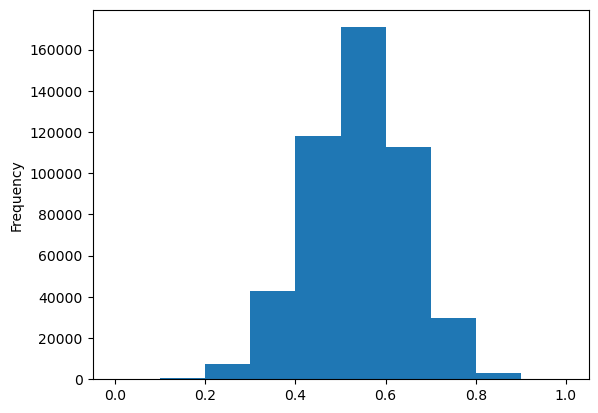

In [71]:
pd.Series(minmax_scale(scaler.fit_transform(df_final[df_final['fault'] == 0]['DE'].values.reshape(-1, 1)).flatten())).plot(kind = 'hist')

In [98]:
lstm_ee = lstm.LSTMModel(input_size = 1, hidden_size = 128, num_layers = 3, output_size = 1)

In [62]:
lstm_ee_fit, time_per_epoch, cum_energy_per_epoch = lstm_ee.train_lstm_and_track_time_and_efficiency(train_loader, val_loader, num_epochs=20, learning_rate=0.005)

[codecarbon INFO @ 11:25:34] [setup] RAM Tracking...
[codecarbon INFO @ 11:25:34] [setup] CPU Tracking...
[codecarbon WARNING @ 11:25:34] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 11:25:35] We saw that you have a AMD Ryzen 7 6800H with Radeon Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 11:25:35] CPU Model on constant consumption mode: AMD Ryzen 7 6800H with Radeon Graphics
[codecarbon INFO @ 11:25:35] [setup] GPU Tracking...
[codecarbon INFO @ 11:25:35] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:25:35] >>> Tracker's metadata:
[codecarbon INFO @ 11:25:35]   Platform system: Windows-11-10.0.22631-SP0
[codecarbon INFO @ 11:25:35]   Python version: 3.12.7
[codecarbon INFO @ 11:25:35]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 11:25:35]   Available RAM : 31.192 GB
[codecarbon INFO @ 11:25:35]   CPU count: 16
[codecarbon INFO @ 11:25:35]  

53650
Epoch [1/20], Train Loss: 1.0096, Val Loss: 1.0638, Energy Used: 2116.92 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 11:26:20] Energy consumed for RAM : 0.000146 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:26:20] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:26:20] Energy consumed for all GPUs : 0.000537 kWh. Total GPU Power : 46.00850273675369 W
[codecarbon INFO @ 11:26:20] 0.001214 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:26:35] Energy consumed for RAM : 0.000195 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:26:35] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:26:35] Energy consumed for all GPUs : 0.000702 kWh. Total GPU Power : 39.612092329479005 W
[codecarbon INFO @ 11:26:35] 0.001605 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:26:50] Energy consumed for RAM : 0.000244 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:26:50] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codec

55477
Epoch [2/20], Train Loss: 1.0098, Val Loss: 1.0058, Energy Used: 2129.36 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 11:27:05] Energy consumed for RAM : 0.000292 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:27:05] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:27:05] Energy consumed for all GPUs : 0.001063 kWh. Total GPU Power : 46.65705987754238 W
[codecarbon INFO @ 11:27:05] 0.002419 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:27:20] Energy consumed for RAM : 0.000341 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:27:20] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:27:20] Energy consumed for all GPUs : 0.001233 kWh. Total GPU Power : 40.66431216473216 W
[codecarbon INFO @ 11:27:20] 0.002814 kWh of electricity used since the beginning.


53552
Epoch [3/20], Train Loss: 1.0104, Val Loss: 1.0060, Energy Used: 2045.49 J


[codecarbon INFO @ 11:27:35] Energy consumed for RAM : 0.000390 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:27:35] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:27:35] Energy consumed for all GPUs : 0.001429 kWh. Total GPU Power : 47.08116850330704 W
[codecarbon INFO @ 11:27:35] 0.003236 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:27:35] 0.009039 g.CO2eq/s mean an estimation of 285.0526601401323 kg.CO2eq/year
[codecarbon INFO @ 11:27:50] Energy consumed for RAM : 0.000439 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:27:50] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:27:50] Energy consumed for all GPUs : 0.001593 kWh. Total GPU Power : 39.235362071975615 W
[codecarbon INFO @ 11:27:50] 0.003625 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:05] Energy consumed for RAM : 0.000487 kWh. RAM Power : 11.697037696838379 W
[co

54222
Epoch [4/20], Train Loss: 1.0096, Val Loss: 1.0202, Energy Used: 2064.62 J


[codecarbon INFO @ 11:28:20] Energy consumed for RAM : 0.000536 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:28:20] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:28:20] Energy consumed for all GPUs : 0.001955 kWh. Total GPU Power : 46.04954885993568 W
[codecarbon INFO @ 11:28:20] 0.004440 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:35] Energy consumed for RAM : 0.000585 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:28:35] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:28:35] Energy consumed for all GPUs : 0.002133 kWh. Total GPU Power : 42.56978505053505 W
[codecarbon INFO @ 11:28:35] 0.004843 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:47] Energy consumed for RAM : 0.000624 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:28:48] Energy consumed for all CPUs : 0.002269 kWh. Total CPU Power : 42.5 W
[codeca

55277
Epoch [5/20], Train Loss: 1.0094, Val Loss: 1.0270, Energy Used: 2105.13 J
Early stopping triggered.
Training complete! Time to converge: 192.22 seconds
Cumulative GPU Energy Used: 10461.52 Joules


In [99]:
lstm_ee_fit_mm, time_per_epoch_mm, cum_energy_per_epoch_mm = lstm_ee.train_lstm_and_track_time_and_efficiency(train_loader_mm, val_loader_mm, num_epochs=20, learning_rate=0.05)

[codecarbon INFO @ 17:14:45] [setup] RAM Tracking...
[codecarbon INFO @ 17:14:45] [setup] CPU Tracking...
[codecarbon WARNING @ 17:14:45] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 17:14:47] We saw that you have a AMD Ryzen 7 6800H with Radeon Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 17:14:47] CPU Model on constant consumption mode: AMD Ryzen 7 6800H with Radeon Graphics
[codecarbon INFO @ 17:14:47] [setup] GPU Tracking...
[codecarbon INFO @ 17:14:47] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:14:47] >>> Tracker's metadata:
[codecarbon INFO @ 17:14:47]   Platform system: Windows-11-10.0.22631-SP0
[codecarbon INFO @ 17:14:47]   Python version: 3.12.7
[codecarbon INFO @ 17:14:47]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 17:14:47]   Available RAM : 31.192 GB
[codecarbon INFO @ 17:14:47]   CPU count: 16
[codecarbon INFO @ 17:14:47]  

63474
Epoch [1/20], Train Loss: 0.0342, Val Loss: 0.0169, Energy Used: 878.59 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 17:15:02] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 17:15:02] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:15:02] Energy consumed for all GPUs : 0.000307 kWh. Total GPU Power : 73.50632964938595 W
[codecarbon INFO @ 17:15:02] 0.000533 kWh of electricity used since the beginning.


63967
Epoch [2/20], Train Loss: 0.0127, Val Loss: 0.0135, Energy Used: 894.60 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 17:15:17] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 17:15:17] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:15:17] Energy consumed for all GPUs : 0.000617 kWh. Total GPU Power : 74.38479197176191 W
[codecarbon INFO @ 17:15:17] 0.001069 kWh of electricity used since the beginning.


64659
Epoch [3/20], Train Loss: 0.0129, Val Loss: 0.0122, Energy Used: 915.44 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 17:15:32] Energy consumed for RAM : 0.000146 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 17:15:32] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:15:32] Energy consumed for all GPUs : 0.000927 kWh. Total GPU Power : 74.46830156516096 W
[codecarbon INFO @ 17:15:32] 0.001605 kWh of electricity used since the beginning.


65942
Epoch [4/20], Train Loss: 0.0128, Val Loss: 0.0123, Energy Used: 926.79 J


[codecarbon INFO @ 17:15:47] Energy consumed for RAM : 0.000195 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 17:15:47] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:15:47] Energy consumed for all GPUs : 0.001245 kWh. Total GPU Power : 76.36155385167633 W
[codecarbon INFO @ 17:15:47] 0.002149 kWh of electricity used since the beginning.


65753
Epoch [5/20], Train Loss: 0.0128, Val Loss: 0.0129, Energy Used: 959.56 J


[codecarbon INFO @ 17:16:02] Energy consumed for RAM : 0.000244 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 17:16:02] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:16:02] Energy consumed for all GPUs : 0.001568 kWh. Total GPU Power : 77.50241525784877 W
[codecarbon INFO @ 17:16:02] 0.002698 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:16:12] Energy consumed for RAM : 0.000276 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 17:16:12] Energy consumed for all CPUs : 0.001002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:16:12] Energy consumed for all GPUs : 0.001784 kWh. Total GPU Power : 79.20505010170466 W
[codecarbon INFO @ 17:16:12] 0.003062 kWh of electricity used since the beginning.


65480
Epoch [6/20], Train Loss: 0.0129, Val Loss: 0.0126, Energy Used: 931.73 J
Early stopping triggered.
Training complete! Time to converge: 84.89 seconds
Cumulative GPU Energy Used: 5506.71 Joules


### Use healthy ICE model as a starting point for EE

In [83]:
lstm_ee_tl = lstm.LSTMModel(input_size = 1, hidden_size = 128, num_layers = 3, output_size = 1)
lstm_ee_tl.load_model(r"D:\Repositories\PhD\models\healthy_lstm_ICE.pth")

Model successfully loaded from 'D:\Repositories\PhD\models\healthy_lstm_ICE.pth'


D:\Repositories\PhD\src\classes\lstm.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(file_path, map_location=self.device))


True

In [84]:
lstm_ee_fit_mm_tl, time_per_epoch_mm_tl, cum_energy_per_epoch_mm_tl = lstm_ee_tl.train_lstm_and_track_time_and_efficiency(train_loader_mm, val_loader_mm, num_epochs=20, learning_rate=0.01)

[codecarbon INFO @ 16:36:11] [setup] RAM Tracking...
[codecarbon INFO @ 16:36:11] [setup] CPU Tracking...
[codecarbon WARNING @ 16:36:11] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 16:36:13] We saw that you have a AMD Ryzen 7 6800H with Radeon Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 16:36:13] CPU Model on constant consumption mode: AMD Ryzen 7 6800H with Radeon Graphics
[codecarbon INFO @ 16:36:13] [setup] GPU Tracking...
[codecarbon INFO @ 16:36:13] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:36:13] >>> Tracker's metadata:
[codecarbon INFO @ 16:36:13]   Platform system: Windows-11-10.0.22631-SP0
[codecarbon INFO @ 16:36:13]   Python version: 3.12.7
[codecarbon INFO @ 16:36:13]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 16:36:13]   Available RAM : 31.192 GB
[codecarbon INFO @ 16:36:13]   CPU count: 16
[codecarbon INFO @ 16:36:13]  

54427
Epoch [1/20], Train Loss: 0.0121, Val Loss: 0.0121, Energy Used: 2155.58 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 16:36:58] Energy consumed for RAM : 0.000146 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:36:58] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:36:58] Energy consumed for all GPUs : 0.000573 kWh. Total GPU Power : 49.588118501490904 W
[codecarbon INFO @ 16:36:58] 0.001251 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:13] Energy consumed for RAM : 0.000195 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:37:13] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:37:13] Energy consumed for all GPUs : 0.000770 kWh. Total GPU Power : 47.40569086793307 W
[codecarbon INFO @ 16:37:13] 0.001674 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:28] Energy consumed for RAM : 0.000244 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:37:28] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codec

55336
Epoch [2/20], Train Loss: 0.0121, Val Loss: 0.0123, Energy Used: 2219.00 J


[codecarbon INFO @ 16:37:43] Energy consumed for RAM : 0.000293 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:37:43] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:37:43] Energy consumed for all GPUs : 0.001179 kWh. Total GPU Power : 52.52662040301046 W
[codecarbon INFO @ 16:37:43] 0.002534 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:58] Energy consumed for RAM : 0.000341 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:37:58] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:37:58] Energy consumed for all GPUs : 0.001370 kWh. Total GPU Power : 45.80739056723475 W
[codecarbon INFO @ 16:37:58] 0.002951 kWh of electricity used since the beginning.


55832
Epoch [3/20], Train Loss: 0.0121, Val Loss: 0.0120, Energy Used: 2240.58 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 16:38:13] Energy consumed for RAM : 0.000390 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:38:13] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:38:13] Energy consumed for all GPUs : 0.001583 kWh. Total GPU Power : 51.01357044177588 W
[codecarbon INFO @ 16:38:13] 0.003390 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:13] 0.009467 g.CO2eq/s mean an estimation of 298.53703990346156 kg.CO2eq/year
[codecarbon INFO @ 16:38:28] Energy consumed for RAM : 0.000439 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:38:28] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:38:28] Energy consumed for all GPUs : 0.001784 kWh. Total GPU Power : 48.259619937788614 W
[codecarbon INFO @ 16:38:28] 0.003817 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:43] Energy consumed for RAM : 0.000488 kWh. RAM Power : 11.697037696838379 W
[c

56497
Epoch [4/20], Train Loss: 0.0121, Val Loss: 0.0121, Energy Used: 2268.98 J


[codecarbon INFO @ 16:38:58] Energy consumed for RAM : 0.000536 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:38:58] Energy consumed for all CPUs : 0.001949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:38:58] Energy consumed for all GPUs : 0.002204 kWh. Total GPU Power : 54.3634295412599 W
[codecarbon INFO @ 16:38:58] 0.004689 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:13] Energy consumed for RAM : 0.000585 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:39:13] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:39:13] Energy consumed for all GPUs : 0.002392 kWh. Total GPU Power : 45.30172186166113 W
[codecarbon INFO @ 16:39:13] 0.005104 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:28] Energy consumed for RAM : 0.000634 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:39:28] Energy consumed for all CPUs : 0.002303 kWh. Total CPU Power : 42.5 W
[codecar

55391
Epoch [5/20], Train Loss: 0.0121, Val Loss: 0.0120, Energy Used: 2226.47 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 16:39:43] Energy consumed for RAM : 0.000683 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:39:43] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:39:43] Energy consumed for all GPUs : 0.002802 kWh. Total GPU Power : 50.867516061535575 W
[codecarbon INFO @ 16:39:43] 0.005965 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:58] Energy consumed for RAM : 0.000731 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:39:58] Energy consumed for all CPUs : 0.002658 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:39:58] Energy consumed for all GPUs : 0.002998 kWh. Total GPU Power : 46.99942350383654 W
[codecarbon INFO @ 16:39:58] 0.006387 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:13] Energy consumed for RAM : 0.000780 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:40:13] Energy consumed for all CPUs : 0.002835 kWh. Total CPU Power : 42.5 W
[codec

55425
Epoch [6/20], Train Loss: 0.0121, Val Loss: 0.0121, Energy Used: 2253.00 J


[codecarbon INFO @ 16:40:28] Energy consumed for RAM : 0.000829 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:40:28] Energy consumed for all CPUs : 0.003012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:40:28] Energy consumed for all GPUs : 0.003396 kWh. Total GPU Power : 48.73375734483723 W
[codecarbon INFO @ 16:40:28] 0.007237 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:43] Energy consumed for RAM : 0.000878 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:40:43] Energy consumed for all CPUs : 0.003189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:40:43] Energy consumed for all GPUs : 0.003581 kWh. Total GPU Power : 44.18549975824154 W
[codecarbon INFO @ 16:40:43] 0.007647 kWh of electricity used since the beginning.


55705
Epoch [7/20], Train Loss: 0.0121, Val Loss: 0.0121, Energy Used: 2220.97 J


[codecarbon INFO @ 16:40:58] Energy consumed for RAM : 0.000926 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:40:58] Energy consumed for all CPUs : 0.003366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:40:58] Energy consumed for all GPUs : 0.003776 kWh. Total GPU Power : 46.956799092098244 W
[codecarbon INFO @ 16:40:58] 0.008069 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:13] Energy consumed for RAM : 0.000975 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:41:13] Energy consumed for all CPUs : 0.003543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:41:13] Energy consumed for all GPUs : 0.003958 kWh. Total GPU Power : 43.57077663224701 W
[codecarbon INFO @ 16:41:13] 0.008476 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:28] Energy consumed for RAM : 0.001024 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 16:41:28] Energy consumed for all CPUs : 0.003720 kWh. Total CPU Power : 42.5 W
[codec

56281
Epoch [8/20], Train Loss: 0.0121, Val Loss: 0.0121, Energy Used: 2129.38 J
Early stopping triggered.
Training complete! Time to converge: 318.58 seconds
Cumulative GPU Energy Used: 17713.97 Joules


In [24]:
import matplotlib.pyplot as plt

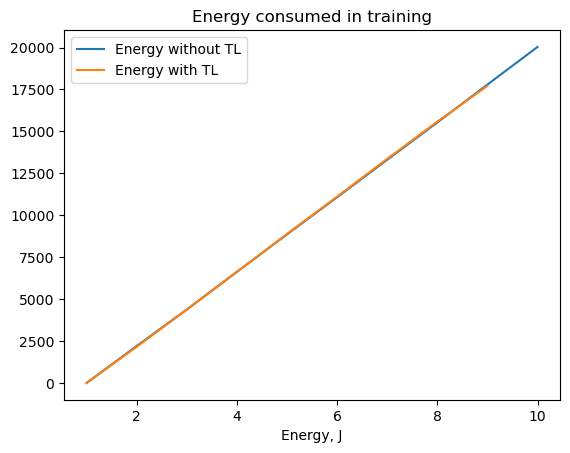

In [88]:
plt.plot(range(1, len(cum_energy_per_epoch_mm)+1), cum_energy_per_epoch_mm, label = 'Energy without TL')
plt.plot(range(1, len(cum_energy_per_epoch_mm_tl)+1), cum_energy_per_epoch_mm_tl, label = 'Energy with TL')
plt.xlabel('Epoch')
plt.xlabel('Energy, J')
plt.title('Energy consumed in training')
plt.legend()

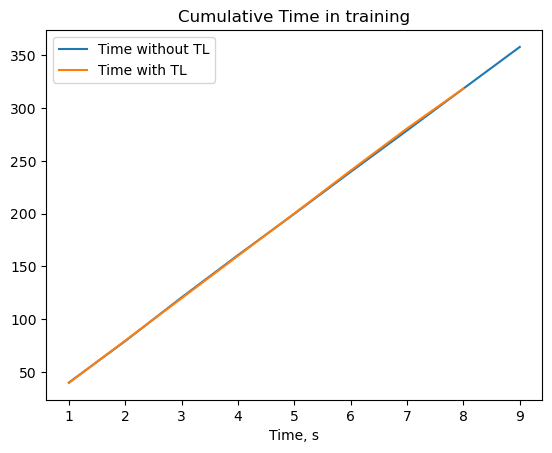

In [89]:
plt.plot(range(1, len(time_per_epoch_mm)+1), time_per_epoch_mm, label = 'Time without TL')
plt.plot(range(1, len(time_per_epoch_mm_tl)+1), time_per_epoch_mm_tl, label = 'Time with TL')
plt.xlabel('Epoch')
plt.xlabel('Time, s')
plt.title('Cumulative Time in training')
plt.legend()

Text(0.5, 0, 'Epoch')

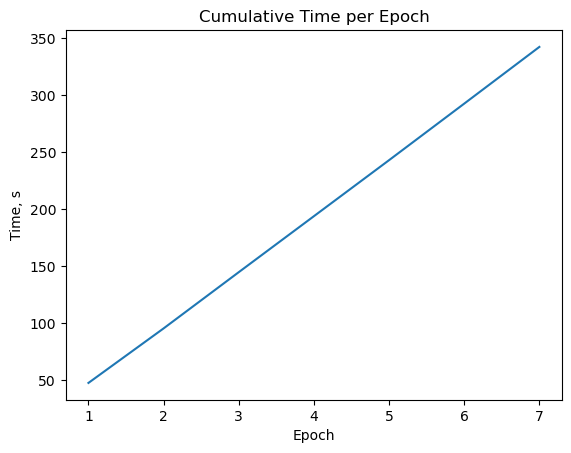

In [45]:
plt.plot(range(1, len(time_per_epoch)+1), time_per_epoch)
plt.title("Cumulative Time per Epoch")
plt.ylabel('Time, s')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

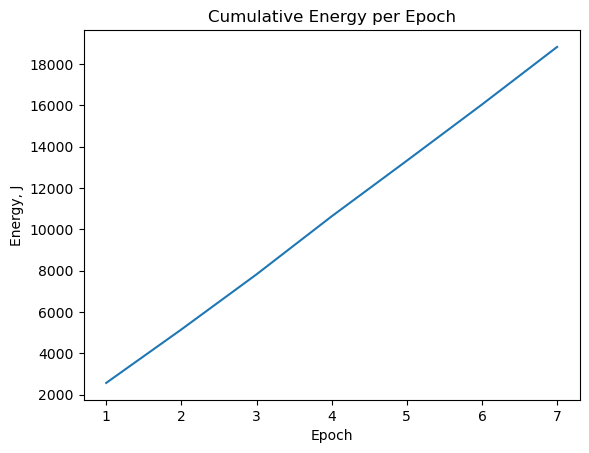

In [41]:
plt.plot(range(1, len(cum_energy_per_epoch)), cum_energy_per_epoch[1:])
plt.title("Cumulative Energy per Epoch")
plt.ylabel('Energy, J')
plt.xlabel('Epoch')

In [47]:
emisions_df = pd.read_csv('emissions.csv')

In [48]:
emisions_df

,timestamp,project_name,run_id,experiment_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,...,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud,pue
0,2025-03-16T20:01:37,codecarbon,5c36cffe-1319-41d8-aa75-3c0da269cb1e,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,46.492171,0.000417,0.000009,42.5,63.561500,11.697038,...,16,AMD Ryzen 7 6800H with Radeon Graphics,1,1 x NVIDIA GeForce RTX 3060 Laptop GPU,23.3223,42.6826,31.192101,machine,N,1.0
1,2025-03-16T20:04:32,codecarbon,734571c9-a510-4538-97e2-a405634e1ae6,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,47.582546,0.000430,0.000009,42.5,64.182242,11.697038,...,16,AMD Ryzen 7 6800H with Radeon Graphics,1,1 x NVIDIA GeForce RTX 3060 Laptop GPU,23.3223,42.6826,31.192101,machine,N,1.0
2,2025-03-16T20:06:24,codecarbon,cd83d053-c565-462a-88ca-39b60c21638c,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,46.866050,0.000422,0.000009,42.5,65.754074,11.697038,...,16,AMD Ryzen 7 6800H with Radeon Graphics,1,1 x NVIDIA GeForce RTX 3060 Laptop GPU,23.3223,42.6826,31.192101,machine,N,1.0
3,2025-03-16T20:08:13,codecarbon,6aca22cb-b8ad-4ae1-9a54-1d3d51e151b0,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,47.874468,0.000438,0.000009,42.5,58.631904,11.697038,...,16,AMD Ryzen 7 6800H with Radeon Graphics,1,1 x NVIDIA GeForce RTX 3060 Laptop GPU,23.3223,42.6826,31.192101,machine,N,1.0
4,2025-03-16T20:09:44,codecarbon,cf495b90-e11f-4300-838d-96fdff1a32ea,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,47.869385,0.000432,0.000009,42.5,60.760024,11.697038,...,16,AMD Ryzen 7 6800H with Radeon Graphics,1,1 x NVIDIA GeForce RTX 3060 Laptop GPU,23.3223,42.6826,31.192101,machine,N,1.0
5,2025-03-16T20:11:56,codecarbon,d42cb6dd-470a-4cd5-9b14-7ed8eeb362a3,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,47.945325,0.000429,0.000009,42.5,57.215963,11.697038,...,16,AMD Ryzen 7 6800H with Radeon Graphics,1,1 x NVIDIA GeForce RTX 3060 Laptop GPU,23.3223,42.6826,31.192101,machine,N,1.0
6,2025-03-16T20:19:35,codecarbon,cb847467-a004-4d0a-b7d7-32b32cc4f12a,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,342.370293,0.003089,0.000009,42.5,43.885722,11.697038,...,16,AMD Ryzen 7 6800H with Radeon Graphics,1,1 x NVIDIA GeForce RTX 3060 Laptop GPU,23.3223,42.6826,31.192101,machine,N,1.0


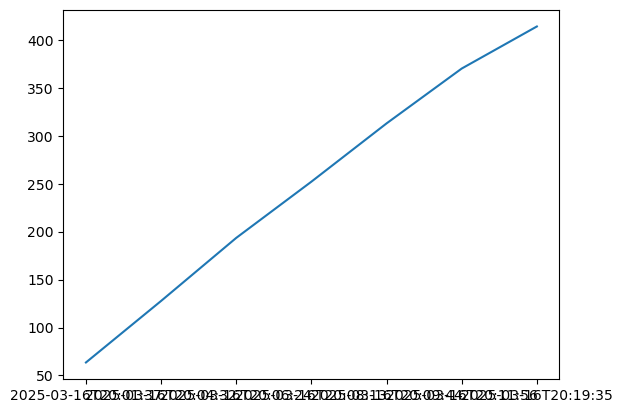

In [53]:
plt.plot(emisions_df['timestamp'], emisions_df['gpu_power'].cumsum())

#### Transfer ICE parameters to the EE network

In [63]:
lstm_ee_tl = lstm.LSTMModel(input_size = 1, hidden_size = 128, num_layers = 3, output_size = 1)

In [64]:
lstm_ee_tl.load_model(file_path=r"D:\Repositories\PhD\models\healthy_lstm.pth")

Model successfully loaded from 'D:\Repositories\PhD\models\healthy_lstm.pth'


D:\Repositories\PhD\src\classes\lstm.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(file_path, map_location=self.device))


True

In [65]:
lstm_ee_fit_tl, time_per_epoch_tl, cum_energy_per_epoch_tl = lstm_ee_tl.train_lstm_and_track_time_and_efficiency(train_loader, val_loader, num_epochs=20, learning_rate=0.005)

[codecarbon INFO @ 11:33:17] [setup] RAM Tracking...
[codecarbon INFO @ 11:33:17] [setup] CPU Tracking...
[codecarbon WARNING @ 11:33:17] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 11:33:19] We saw that you have a AMD Ryzen 7 6800H with Radeon Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 11:33:19] CPU Model on constant consumption mode: AMD Ryzen 7 6800H with Radeon Graphics
[codecarbon INFO @ 11:33:19] [setup] GPU Tracking...
[codecarbon INFO @ 11:33:19] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:33:19] >>> Tracker's metadata:
[codecarbon INFO @ 11:33:19]   Platform system: Windows-11-10.0.22631-SP0
[codecarbon INFO @ 11:33:19]   Python version: 3.12.7
[codecarbon INFO @ 11:33:19]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 11:33:19]   Available RAM : 31.192 GB
[codecarbon INFO @ 11:33:19]   CPU count: 16
[codecarbon INFO @ 11:33:19]  

54282
Epoch [1/20], Train Loss: 1.0022, Val Loss: 1.0027, Energy Used: 2143.05 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 11:34:04] Energy consumed for RAM : 0.000146 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:34:04] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:34:04] Energy consumed for all GPUs : 0.000545 kWh. Total GPU Power : 46.80108333104406 W
[codecarbon INFO @ 11:34:04] 0.001222 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:34:19] Energy consumed for RAM : 0.000195 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:34:19] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:34:19] Energy consumed for all GPUs : 0.000720 kWh. Total GPU Power : 42.090751206701995 W
[codecarbon INFO @ 11:34:19] 0.001624 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:34:34] Energy consumed for RAM : 0.000244 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:34:34] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codec

54329
Epoch [2/20], Train Loss: 0.9999, Val Loss: 1.0027, Energy Used: 2152.68 J


[codecarbon INFO @ 11:34:49] Energy consumed for RAM : 0.000293 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:34:49] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:34:49] Energy consumed for all GPUs : 0.001096 kWh. Total GPU Power : 49.20445333788489 W
[codecarbon INFO @ 11:34:49] 0.002452 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:35:04] Energy consumed for RAM : 0.000341 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:35:04] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:35:04] Energy consumed for all GPUs : 0.001266 kWh. Total GPU Power : 40.69587274627127 W
[codecarbon INFO @ 11:35:04] 0.002847 kWh of electricity used since the beginning.


54283
Epoch [3/20], Train Loss: 0.9999, Val Loss: 1.0028, Energy Used: 2156.01 J


[codecarbon INFO @ 11:35:19] Energy consumed for RAM : 0.000390 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:35:19] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:35:19] Energy consumed for all GPUs : 0.001455 kWh. Total GPU Power : 45.33615576195521 W
[codecarbon INFO @ 11:35:19] 0.003262 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:35:19] 0.009110 g.CO2eq/s mean an estimation of 287.3037576616025 kg.CO2eq/year
[codecarbon INFO @ 11:35:34] Energy consumed for RAM : 0.000439 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:35:34] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:35:34] Energy consumed for all GPUs : 0.001632 kWh. Total GPU Power : 42.488798837798235 W
[codecarbon INFO @ 11:35:34] 0.003665 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:35:49] Energy consumed for RAM : 0.000487 kWh. RAM Power : 11.697037696838379 W
[co

53954
Epoch [4/20], Train Loss: 1.0000, Val Loss: 1.0026, Energy Used: 2129.62 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 11:36:04] Energy consumed for RAM : 0.000536 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:36:04] Energy consumed for all CPUs : 0.001949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:36:04] Energy consumed for all GPUs : 0.002000 kWh. Total GPU Power : 47.09633118056415 W
[codecarbon INFO @ 11:36:04] 0.004485 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:36:19] Energy consumed for RAM : 0.000585 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:36:19] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:36:19] Energy consumed for all GPUs : 0.002169 kWh. Total GPU Power : 40.582830674379494 W
[codecarbon INFO @ 11:36:19] 0.004880 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:36:34] Energy consumed for RAM : 0.000634 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:36:34] Energy consumed for all CPUs : 0.002303 kWh. Total CPU Power : 42.5 W
[codec

54791
Epoch [5/20], Train Loss: 1.0000, Val Loss: 1.0027, Energy Used: 2177.24 J


[codecarbon INFO @ 11:36:49] Energy consumed for RAM : 0.000682 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:36:49] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:36:49] Energy consumed for all GPUs : 0.002539 kWh. Total GPU Power : 47.67572252347714 W
[codecarbon INFO @ 11:36:49] 0.005701 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:37:04] Energy consumed for RAM : 0.000731 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:37:04] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:37:04] Energy consumed for all GPUs : 0.002711 kWh. Total GPU Power : 41.43381774650539 W
[codecarbon INFO @ 11:37:04] 0.006099 kWh of electricity used since the beginning.


54937
Epoch [6/20], Train Loss: 0.9999, Val Loss: 1.0027, Energy Used: 2173.43 J


[codecarbon INFO @ 11:37:19] Energy consumed for RAM : 0.000780 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:37:19] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:37:19] Energy consumed for all GPUs : 0.002904 kWh. Total GPU Power : 46.26220163294867 W
[codecarbon INFO @ 11:37:19] 0.006518 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:37:19] 0.009096 g.CO2eq/s mean an estimation of 286.8553900345896 kg.CO2eq/year
[codecarbon INFO @ 11:37:34] Energy consumed for RAM : 0.000829 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:37:34] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:37:34] Energy consumed for all GPUs : 0.003082 kWh. Total GPU Power : 42.69587712705651 W
[codecarbon INFO @ 11:37:34] 0.006922 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:37:49] Energy consumed for RAM : 0.000877 kWh. RAM Power : 11.697037696838379 W
[cod

55118
Epoch [7/20], Train Loss: 1.0000, Val Loss: 1.0026, Energy Used: 2181.18 J
Model saved to best_lstm_model_EE.pth


[codecarbon INFO @ 11:38:04] Energy consumed for RAM : 0.000926 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:38:04] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:38:04] Energy consumed for all GPUs : 0.003459 kWh. Total GPU Power : 48.04961935304795 W
[codecarbon INFO @ 11:38:04] 0.007751 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:38:19] Energy consumed for RAM : 0.000975 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:38:19] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:38:19] Energy consumed for all GPUs : 0.003633 kWh. Total GPU Power : 41.76849469100514 W
[codecarbon INFO @ 11:38:19] 0.008150 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:38:34] Energy consumed for RAM : 0.001024 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:38:34] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codeca

55713
Epoch [8/20], Train Loss: 0.9998, Val Loss: 1.0042, Energy Used: 2227.32 J


[codecarbon INFO @ 11:38:49] Energy consumed for RAM : 0.001072 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:38:49] Energy consumed for all CPUs : 0.003897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:38:49] Energy consumed for all GPUs : 0.004009 kWh. Total GPU Power : 47.10485516230922 W
[codecarbon INFO @ 11:38:49] 0.008977 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:39:04] Energy consumed for RAM : 0.001121 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:39:04] Energy consumed for all CPUs : 0.004074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:39:04] Energy consumed for all GPUs : 0.004177 kWh. Total GPU Power : 40.53116546843258 W
[codecarbon INFO @ 11:39:04] 0.009372 kWh of electricity used since the beginning.


55171
Epoch [9/20], Train Loss: 0.9999, Val Loss: 1.0043, Energy Used: 2185.57 J


[codecarbon INFO @ 11:39:19] Energy consumed for RAM : 0.001170 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:39:19] Energy consumed for all CPUs : 0.004251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:39:19] Energy consumed for all GPUs : 0.004372 kWh. Total GPU Power : 46.7219448393275 W
[codecarbon INFO @ 11:39:19] 0.009793 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:39:19] 0.009148 g.CO2eq/s mean an estimation of 288.4819178941978 kg.CO2eq/year
[codecarbon INFO @ 11:39:34] Energy consumed for RAM : 0.001219 kWh. RAM Power : 11.697037696838379 W
[codecarbon INFO @ 11:39:34] Energy consumed for all CPUs : 0.004428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:39:34] Energy consumed for all GPUs : 0.004544 kWh. Total GPU Power : 41.19382169313457 W
[codecarbon INFO @ 11:39:34] 0.010190 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:39:49] Energy consumed for RAM : 0.001267 kWh. RAM Power : 11.697037696838379 W
[code

54791
Epoch [10/20], Train Loss: 1.0000, Val Loss: 1.0038, Energy Used: 2166.31 J
Early stopping triggered.
Training complete! Time to converge: 396.32 seconds
Cumulative GPU Energy Used: 21692.43 Joules
